/tmp/ipython-input-1569129789.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(nasdaq_top20, start="2023-01-01", end="2025-01-01", group_by='ticker')
[*********************100%***********************]  20 of 20 completed


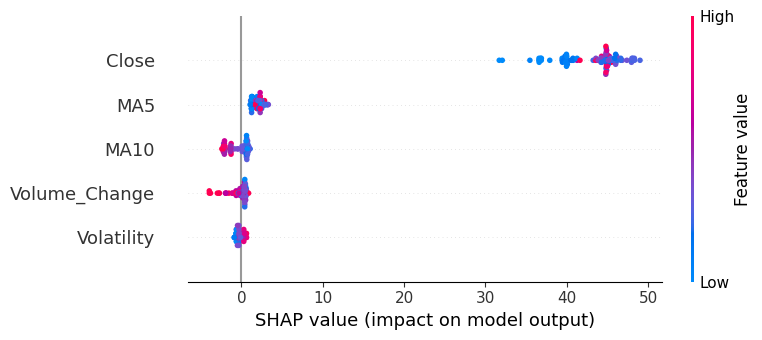

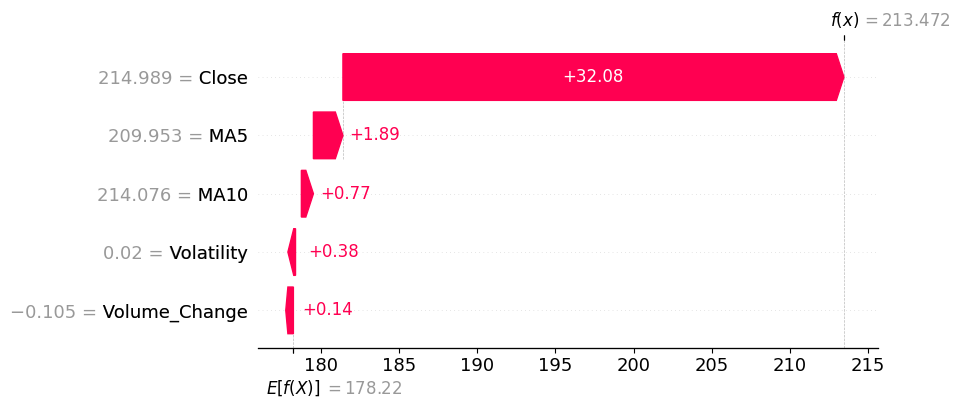

In [1]:
# Install required libraries (if not installed)
# pip install yfinance shap scikit-learn xgboost matplotlib pandas numpy

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Download NASDAQ Top 20 Stocks
# -------------------------
# Example tickers (you can modify for latest top 20)
nasdaq_top20 = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META",
    "NVDA", "TSLA", "PEP", "COST", "AVGO",
    "ADBE", "NFLX", "AMD", "INTC", "CSCO",
    "TXN", "QCOM", "AMGN", "HON", "SBUX"
]

# Download last 2 years of data
data = yf.download(nasdaq_top20, start="2023-01-01", end="2025-01-01", group_by='ticker')

# -------------------------
# Step 2: Feature Engineering
# -------------------------
def create_features(df):
    df['Return'] = df['Close'].pct_change()
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['Volatility'] = df['Return'].rolling(10).std()
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Target'] = df['Close'].shift(-1)  # Next day close (prediction target)
    return df.dropna()

# Example: Apple stock
aapl = data['AAPL'].copy()
aapl = create_features(aapl)

# -------------------------
# Step 3: Train Model
# -------------------------
features = ["Close", "MA5", "MA10", "Volatility", "Volume_Change"]
X = aapl[features]
y = aapl["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# -------------------------
# Step 4: SHAP Explanation
# -------------------------
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Waterfall plot (local explanation for one day)
shap.plots.waterfall(shap_values[0])
